In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from IPython.display import clear_output
import pickle
import time

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from feature_extraction import simple_fe
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model,
                  restore_tags_converted_sales, read_converted_sales)

# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, \
                            weight_calc, make_wrmsse, agg_series)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/level_3_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle
data/prep/level_9_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle
data/prep/norm_level_1.csv
data/prep/level_12_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/p

# Optimise MLP - level 10

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
level = 10

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

categorical_features = {
    1: [],
    2: ['state_id'],
    3: ['state_id', 'store_id'],
    4: ['cat_id'],
    5: ['cat_id', 'dept_id'],
    6: ['state_id', 'cat_id'],
    7: ['state_id', 'cat_id', 'dept_id'],
    8: ['state_id', 'store_id', 'dept_id'],
    9: ['state_id', 'store_id', 'cat_id', 'dept_id'],
    10: ['cat_id', 'dept_id', 'item_id'],
    11: ['state_id', 'cat_id', 'dept_id', 'item_id'],
    12: ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'],
}

## Data preparation (or read saved result)
From `lightgbm-poisson-w-scaled-pinball-loss.ipynb`.  

+ swapperooni with normalised sales. 

Note: categorical features are converted to one-hot encoding by the BatchCreator to reduce memory usage. 

In [ ]:
# read data for pipeline from lightgbm-poisson-w-scaled-pinball-loss.ipynb
calendar, sell_prices, sales_train_val, submission = read_data() # with memory reduction

# read comverted sales
converted_sales = read_converted_sales(level=level, data_dir=data_dir)

### Replace demand with normalised sales
sales_train_val = converted_sales

In [ ]:
NUM_ITEMS = sales_train_val.shape[0]  # 1 / ... / 70 / ... / 30,240
DAYS_PRED = submission.shape[1] - 1   # 28
print(NUM_ITEMS, DAYS_PRED)

In [8]:
if level <= 9:
    nrows = 365 * 6 * NUM_ITEMS  # all
else:
    nrows = 365 * 2 * NUM_ITEMS

In [9]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, categorical_features[level],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 11.16 Mb (0.5% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [10]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', *categorical_features[level]],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))
sales_train_val.head()

Melted sales train validation has 5832737 rows and 6 columns


,id,cat_id,dept_id,item_id,day,demand
0,FOODS_1_001_X,0,0,0,d_1,0.000920
1,FOODS_1_002_X,0,0,1,d_1,0.002878
2,FOODS_1_003_X,0,0,2,d_1,0.003572
3,FOODS_1_004_X,0,0,3,d_1,0.000000
4,FOODS_1_005_X,0,0,4,d_1,0.020737


In [11]:
print("Selecting {} rows ({:.1%})".format(nrows, nrows/sales_train_val.index.size))
data = sales_train_val.iloc[-nrows:,:]

Selecting 2225770 rows (38.2%)


In [12]:
#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
calendar.drop(['weekday', 'wday', 'month', 'year'],
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# add sell price if all of the columns 'store_id', 'item_id', 'wm_yr_wk' are available
#sell price
if np.prod([col in data.columns for col in ['store_id', 'item_id', 'wm_yr_wk']]):
    # get the sell price data (this feature should be very important)
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
    print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memory
del sell_prices
gc.collect()

40

In [13]:
data = reduce_mem_usage(simple_fe(data, DAYS_PRED=DAYS_PRED))

Mem. usage decreased to 184.67 Mb (0.0% reduction)


In [14]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [15]:
print("{:.2f} MB".format(data.memory_usage().sum() / 1024**2))

184.67 MB


### Save prepared dataset
Pickle chosen for its speed. See: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
Feather and parquet both require additional libraries (pyarrow). 

In [16]:
fn = data_dir + 'prep/level_{}_simple_fe_{}_{}_normalised_demand.pickle'.format(
    level, data.date.min().date().strftime("%Y_%m_%d"), data.date.max().date().strftime("%Y_%m_%d")
)
print("Saving to file..")
data.to_pickle(fn)
print("Finished.")

Saving to file..
Finished.


### Read prepared dataset

In [7]:
fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)
data = pd.read_pickle(fn)

In [8]:
features = [
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

# add categorical features, based on availability
features += categorical_features[level]

# add price features, based on availability
if 'sell_price' in data.columns:
    features += [
        # price features
        "sell_price",
        "price_change_t1",
        "price_change_t365",
        "rolling_price_std_t7",
        "rolling_price_std_t30",
    ]

In [9]:
data.head()[features]

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,shift_t28,shift_t29,shift_t30,...,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,cat_id,dept_id,item_id
0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,1
2,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,2
3,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,3
4,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,4


In [10]:
cat_features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
]

available_cat_features = [f for f in cat_features if f in data.columns]

for col in available_cat_features:
    data[col] = data[col].astype('category')

assert len([f for f in available_cat_features if f not in features]) == 0, "right?"

## BatchCreator

In [11]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [18]:
labels = ['demand']
batch_size = 1024#25000
train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=available_cat_features, batch_size=batch_size)

In [19]:
%%time
x, y = next(train_batch_creator.flow())

CPU times: user 139 ms, sys: 105 ms, total: 245 ms
Wall time: 244 ms


## Initialize pinball loss

In [14]:
losses = get_pinball_losses()

## Build model

### Train dense model

In [20]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_simple_dense_model(inp_shape=x[0].shape, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3226)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           206528      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [21]:
logger = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


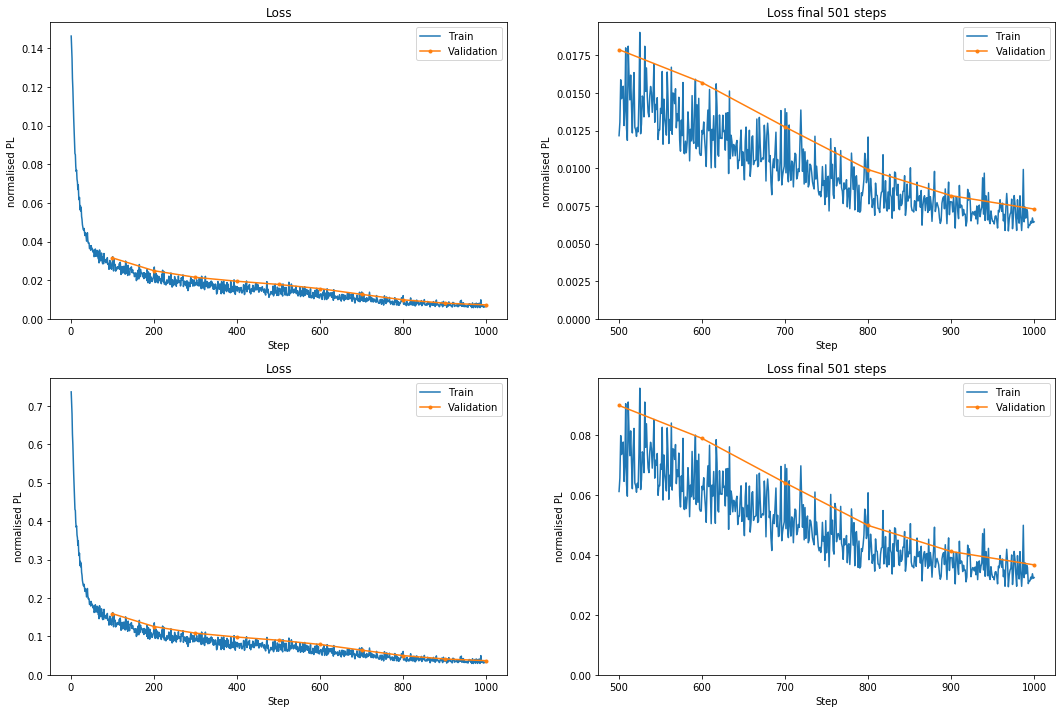

100/100 [==============================] - 59s 590ms/step - loss: 0.0071 - q0_loss: 6.7629e-05 - q1_loss: 2.3478e-04 - q2_loss: 8.8410e-04 - q3_loss: 0.0012 - q4_loss: 0.0015 - q5_loss: 0.0013 - q6_loss: 0.0011 - q7_loss: 5.0741e-04 - q8_loss: 2.8108e-04 - val_loss: 0.0073 - val_q0_loss: 6.3835e-05 - val_q1_loss: 2.7271e-04 - val_q2_loss: 9.2022e-04 - val_q3_loss: 0.0014 - val_q4_loss: 0.0016 - val_q5_loss: 0.0014 - val_q6_loss: 0.0011 - val_q7_loss: 4.4023e-04 - val_q8_loss: 2.0416e-04


In [22]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=10,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.3451419176333993, 'WSPL': 0.3451419176333993}


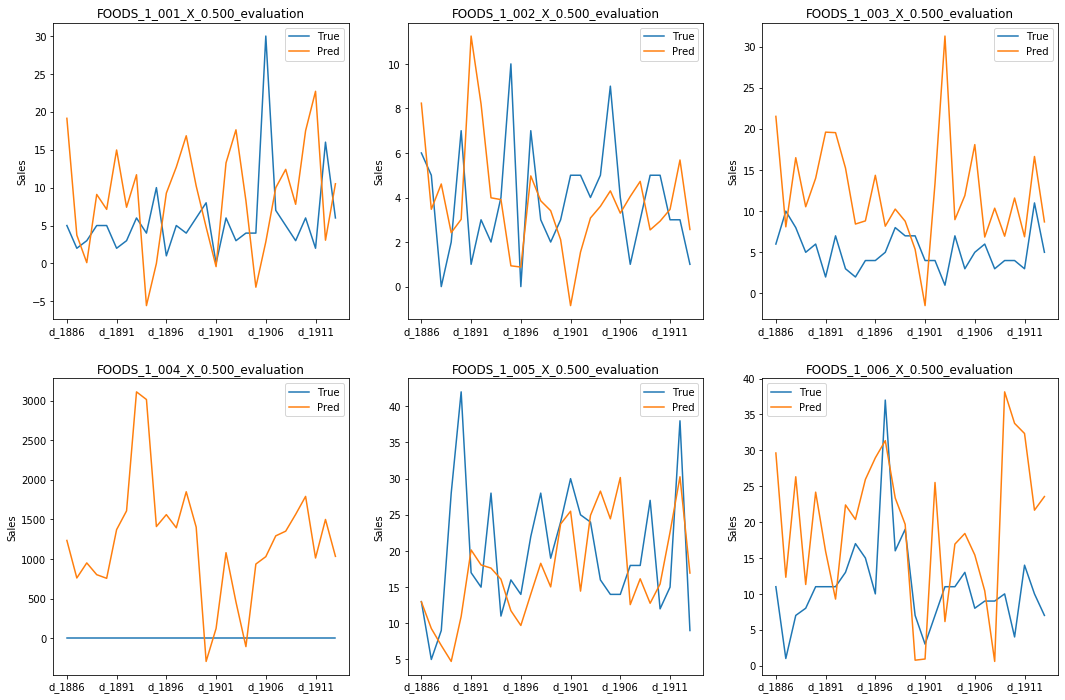

In [23]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [24]:
train_batch_creator.__len__()

2090

Note: a len of 2090 means that one real epoch is about 21 'epochs'. 

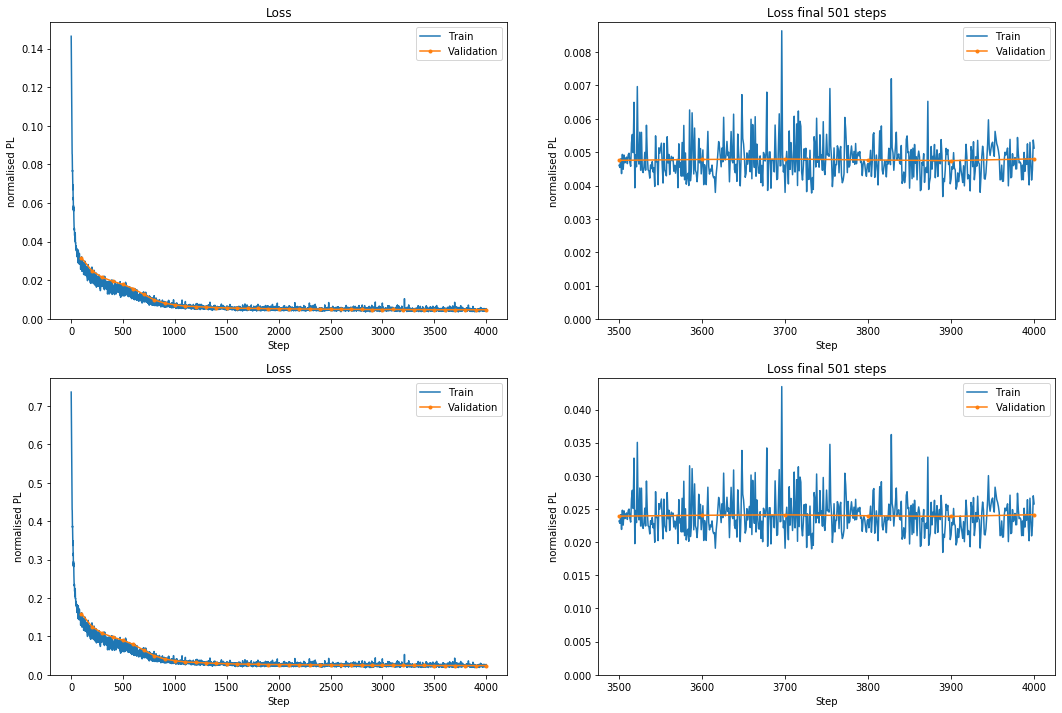

100/100 [==============================] - 55s 552ms/step - loss: 0.0047 - q0_loss: 3.3306e-05 - q1_loss: 1.4769e-04 - q2_loss: 6.4022e-04 - q3_loss: 8.2090e-04 - q4_loss: 0.0011 - q5_loss: 9.0270e-04 - q6_loss: 7.4462e-04 - q7_loss: 2.5566e-04 - q8_loss: 8.9873e-05 - val_loss: 0.0048 - val_q0_loss: 4.0222e-05 - val_q1_loss: 1.7576e-04 - val_q2_loss: 6.4560e-04 - val_q3_loss: 8.2289e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.3811e-04 - val_q6_loss: 7.6475e-04 - val_q7_loss: 2.5643e-04 - val_q8_loss: 8.5254e-05


In [25]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=30,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.23031157717104553, 'WSPL': 0.23031157717104553}


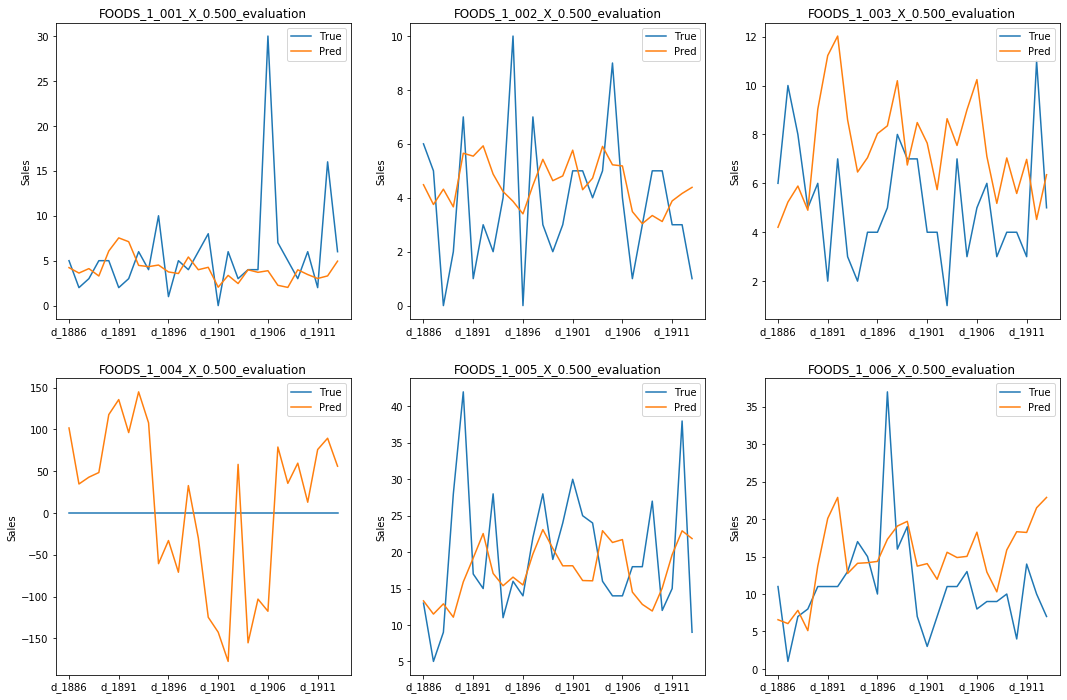

In [26]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [35]:
d_cols = select_day_nums(df, as_int=False)
df[d_cols] = df[d_cols].clip(lower=0)
ref.evaluate_WSPL(df)

{10: 0.2296683487077476, 'WSPL': 0.2296683487077476}

### Train dist model

In [37]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_simple_dist_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3226)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           206528      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [38]:
logger3 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


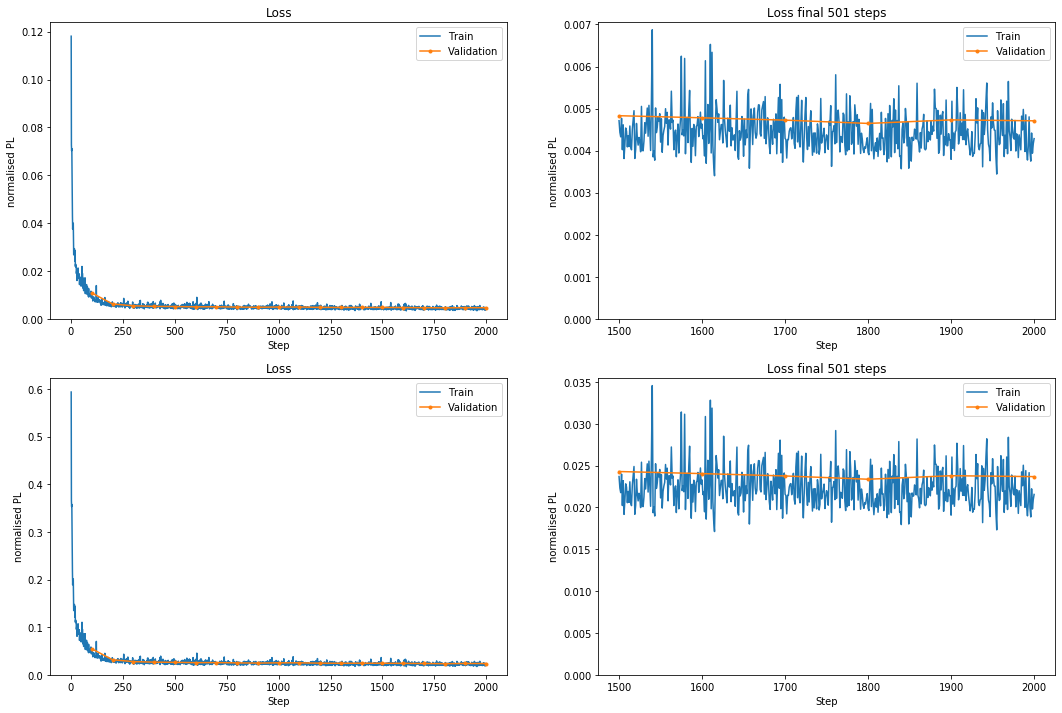

100/100 [==============================] - 39s 389ms/step - loss: 0.0044 - q0_loss: 3.7237e-05 - q1_loss: 1.4529e-04 - q2_loss: 5.9506e-04 - q3_loss: 7.7017e-04 - q4_loss: 0.0010 - q5_loss: 8.6483e-04 - q6_loss: 7.0148e-04 - q7_loss: 2.1104e-04 - q8_loss: 7.9085e-05 - val_loss: 0.0047 - val_q0_loss: 5.1731e-05 - val_q1_loss: 1.7668e-04 - val_q2_loss: 6.6767e-04 - val_q3_loss: 8.4070e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.0161e-04 - val_q6_loss: 7.3270e-04 - val_q7_loss: 2.0749e-04 - val_q8_loss: 6.8632e-05


In [39]:
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger3])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.22487154070446488, 'WSPL': 0.22487154070446488}


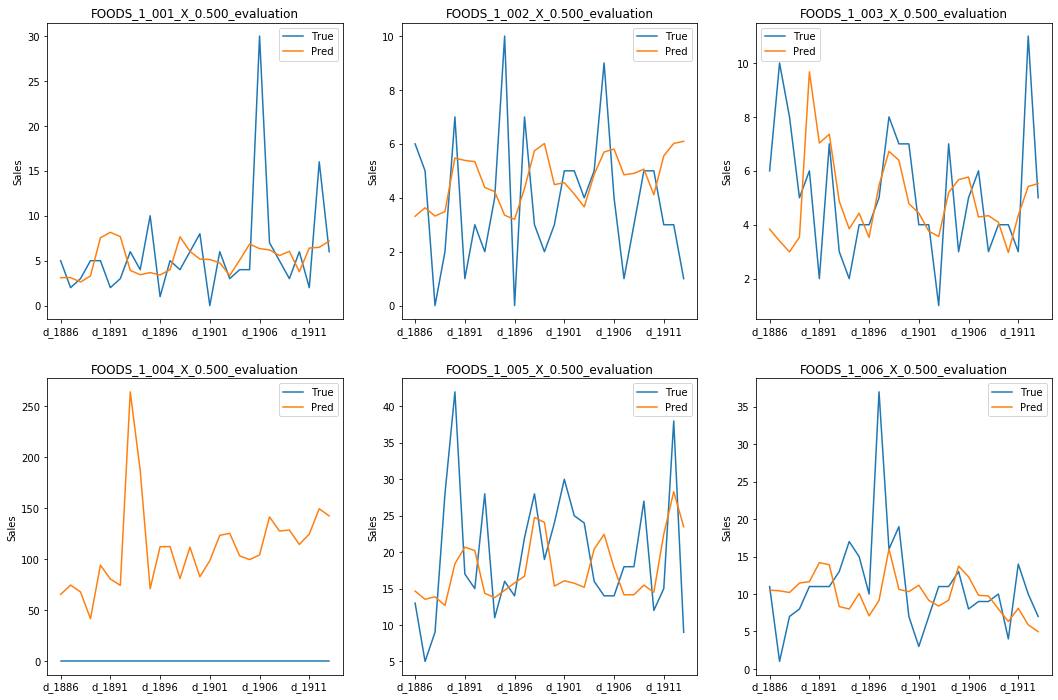

In [40]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### Dist(256)

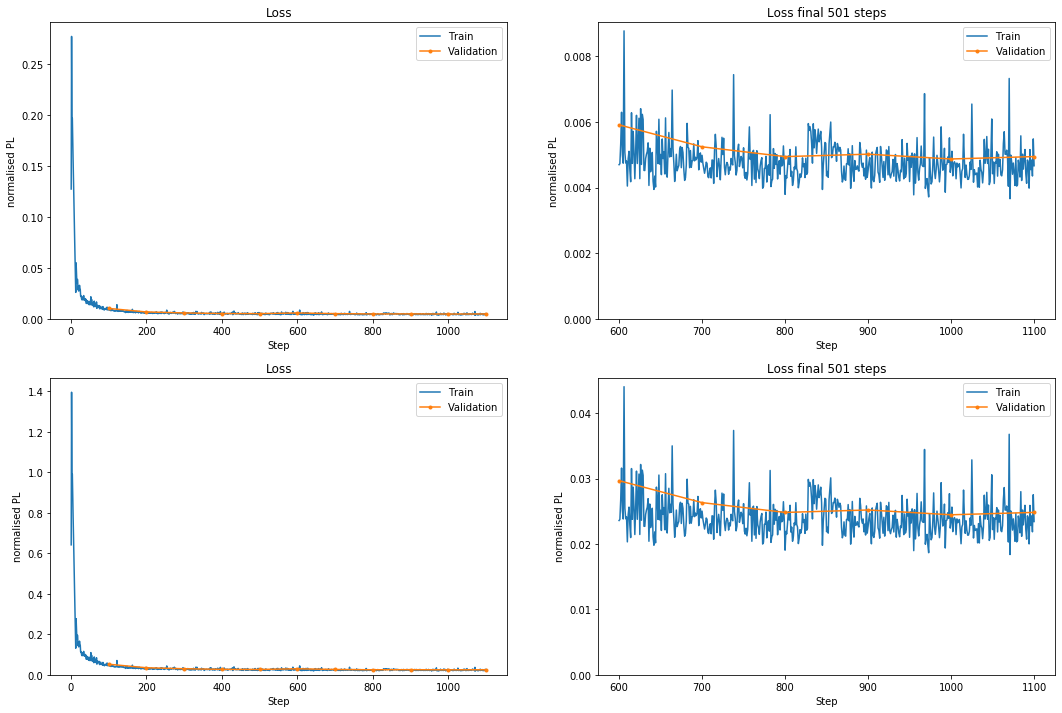

100/100 [==============================] - 46s 463ms/step - loss: 0.0047 - q0_loss: 3.9943e-05 - q1_loss: 1.5325e-04 - q2_loss: 6.2867e-04 - q3_loss: 8.0915e-04 - q4_loss: 0.0011 - q5_loss: 9.1671e-04 - q6_loss: 7.5132e-04 - q7_loss: 2.3784e-04 - q8_loss: 9.4030e-05 - val_loss: 0.0049 - val_q0_loss: 5.3931e-05 - val_q1_loss: 1.8394e-04 - val_q2_loss: 6.8914e-04 - val_q3_loss: 8.6938e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.5330e-04 - val_q6_loss: 7.7753e-04 - val_q7_loss: 2.2384e-04 - val_q8_loss: 7.5323e-05
Epoch 12/20
  1/100 [..............................] - ETA: 45s - loss: 0.0052 - q0_loss: 3.9995e-05 - q1_loss: 1.6123e-04 - q2_loss: 6.4730e-04 - q3_loss: 8.3920e-04 - q4_loss: 0.0012 - q5_loss: 0.0010 - q6_loss: 8.6857e-04 - q7_loss: 3.2853e-04 - q8_loss: 1.6034e-04

In [ ]:
# setup
model = get_simple_dist_model(inp_shape=x[0].shape, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])